# Train finetunned SqueezeNet model for multi-label classification

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from glob import glob
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

import shutil

# Project
project_common_path = os.path.dirname('.')
project_common_path = os.path.abspath(os.path.join(project_common_path, '..', 'common'))
if not project_common_path in sys.path:
    sys.path.append(project_common_path)

In [14]:
import numpy as np

from data_utils import get_id_type_list_for_class, GENERATED_DATA, OUTPUT_PATH, to_set
from training_utils import classification_train as train, classification_validate as validate
from training_utils import exp_decay, step_decay

In [52]:
from models.squeezenet_multiclassification import get_squeezenet, get_squeezenet2

In [5]:
from sklearn.model_selection import KFold, StratifiedKFold
from data_utils import to_set, equalized_data_classes, unique_tags, train_jpg_ids, TRAIN_ENC_CL_CSV
from data_utils import find_best_weights_file, get_label

In [6]:
from xy_providers import image_label_provider

In [59]:
cnn = get_squeezenet2((256, 256, 3), 17)
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 127, 127, 64)  1792        input_18[0][0]                   
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 127, 127, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 63, 63, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

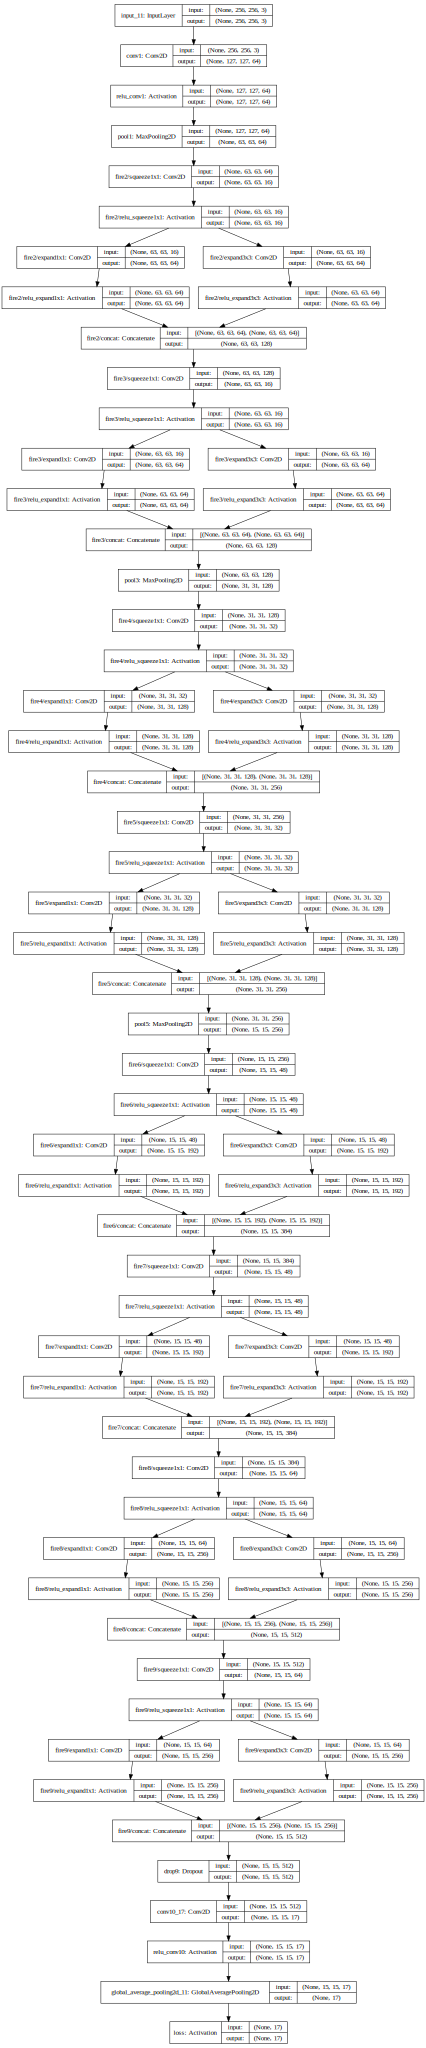

In [45]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

SVG(model_to_dot(cnn, show_shapes=True).create(prog='dot', format='svg'))

## Train on all classes

In [43]:
seed = 2017
np.random.seed(seed)

In [44]:
trainval_id_type_list = [(image_id, "Train_jpg") for image_id in train_jpg_ids]

print(len(trainval_id_type_list))

3000


In [45]:
from data_utils import DataCache

try:
    if cache is None:
        cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
        if os.path.exists(cache_filepath):
            print("Load cache from pickle file")
            cache = load_data_cache(cache_filepath)
        else:
            cache = DataCache(20000)
except NameError:
    cache_filepath = os.path.join(GENERATED_DATA, 'data_cache.pkl')
    if os.path.exists(cache_filepath):
        print("Load cache from pickle file")
        cache = load_data_cache(cache_filepath)
    else:
        cache = DataCache(20000)

In [63]:
params = {
    'seed': seed,
    
    'xy_provider': image_label_provider,
    
    'network': get_squeezenet2,
    'optimizer': 'adadelta',
    'loss': 'categorical_crossentropy',
    'nb_epochs': 100,
    'batch_size': 16,    
    
    'normalize_data': True,
    'normalization': 'vgg',
    
    'image_size': (256, 256),
    
    'lr_kwargs': {
        'lr': 0.01,
        'a': 0.975,
        'init_epoch': 0
    },
    'lr_decay_f': exp_decay,
    
    'cache': cache,
    
    'class_index': 0,
    
#     'pretrained_model': 'load_best',
#     'pretrained_model': os.path.join(GENERATED_DATA, "weights", ""),
        
    'output_path': OUTPUT_PATH,
    
    
}
params['save_prefix'] = '{cnn_name}_seed=%i_all_classes' % params['seed']

params['input_shape'] = params['image_size'] + (3,)
params['n_classes'] = len(unique_tags)

Start CV

In [65]:
n_folds = 5
val_fold_index = 0
val_fold_indices = [0, ]
hists = []

kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
trainval_id_type_list = np.array(trainval_id_type_list)
for train_index, test_index in kf.split(trainval_id_type_list):        
    train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]
    
    if len(val_fold_indices) > 0:
        if val_fold_index not in val_fold_indices:
            val_fold_index += 1
            continue
        
    print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
    val_fold_index += 1

    print(datetime.now(), len(train_id_type_list), len(val_id_type_list))
    assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"

    cnn = params['network'](lr=params['lr_kwargs']['lr'], **params)
    params['save_prefix'] = params['save_prefix'].format(cnn_name=cnn.name)
    print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))
    
    if 'pretrained_model' in params:
        if params['pretrained_model'] == 'load_best':
            weights_files = glob(os.path.join(params['output_path'], "weights", "%s*.h5" % params['save_prefix']))
            assert len(weights_files) > 0, "Failed to load weights"
            best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
            print("Load best loss weights: ", best_weights_filename, best_val_loss)
            cnn.load_weights(best_weights_filename)
        else:
            assert os.path.exist(params['pretrained_model']), "Not found pretrained model"
            print("Load weights: ", params['pretrained_model'])
            cnn.load_weights(params['pretrained_model'], by_name=True)

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(cnn, train_id_type_list, val_id_type_list, **params)    
    if h is None:
        continue
    hists.append(h)



 ---- Validation fold index:  0 / 5
2400 600

 2017-07-04 23:48:23.995063 - Loaded SqueezeNet2 model ...

 2017-07-04 23:48:23.995177 - Start training ...

-- Training parameters: 16, 100, 2416, 608

-- Fit model
- New Keras API found -


INFO (theano.gof.compilelock): Refreshing lock /Users/vfomin/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/vfomin/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.2-64/lock_dir/lock



Epoch validation: score = 0.329226 

Epoch 1/100
151/151 [==============================] - 193s - loss: 9.9257 - precision: 0.1921 - recall: 0.7553 - val_loss: 7.9575 - val_precision: 0.2108 - val_recall: 0.8737

Epoch validation: score = 0.514949 

Epoch 2/100
151/151 [==============================] - 210s - loss: 8.1761 - precision: 0.2149 - recall: 0.8857 - val_loss: 7.8082 - val_precision: 0.2172 - val_recall: 0.9141

Epoch validation: score = 0.531944 

Epoch 3/100
151/151 [==============================] - 204s - loss: 7.8519 - precision: 0.2207 - recall: 0.9142 - val_loss: 7.6290 - val_precision: 0.2235 - val_recall: 0.9238


In [14]:
# output_path = params['output_path'] if 'output_path' in params else OUTPUT_PATH
# weights_path = os.path.join(output_path, "weights")
# weights_filename = os.path.join(weights_path, params['save_prefix'] + "_31_val_loss=6.9420.h5")

# cnn.save_weights(weights_filename)

### Validation all classes

In [10]:
n_runs = 1
n_folds = 5
run_counter = 0
cv_mean_scores = np.zeros((n_runs, n_folds))
val_fold_indices = [0,]

In [11]:
while run_counter < n_runs:    
    run_counter += 1
    print("\n\n ---- New run : ", run_counter, "/", n_runs)
    val_fold_index = 0
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=params['seed'])
    trainval_id_type_list = np.array(trainval_id_type_list)
    for train_index, test_index in kf.split(trainval_id_type_list):        
        train_id_type_list, val_id_type_list = trainval_id_type_list[train_index], trainval_id_type_list[test_index]

        if len(val_fold_indices) > 0:
            if val_fold_index not in val_fold_indices:
                val_fold_index += 1
                continue
        
        print("\n\n ---- Validation fold index: ", val_fold_index, "/", n_folds)
        val_fold_index += 1

        print(len(train_id_type_list), len(val_id_type_list))
        assert len(to_set(train_id_type_list) & to_set(val_id_type_list)) == 0, "WTF"


        cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])
        print("\n {} - Loaded {} model ...".format(datetime.now(), cnn.name))        

        weights_files = glob(os.path.join(OUTPUT_DATA, "weights", "%s*.h5" % params['save_prefix']))
        assert len(weights_files) > 0, "Failed to load weights"
        best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
        print("Load best loss weights: ", best_weights_filename, best_val_loss)
        cnn.load_weights(best_weights_filename)

        score = validate(cnn, val_id_type_list, **params)   
        cv_mean_scores[run_counter-1, val_fold_index-1] = score
    
print(cv_mean_scores)



 ---- New run :  1 / 1


 ---- Validation fold index:  0 / 5
1594 399

 2017-07-02 23:53:40.818343 - Get squeezenet model ...
Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/input/generated/weights/squeezenet_seed=2017_class=0_23_val_loss=0.6935_precision=0.0366_recall=0.3256.h5 0.6935
Image normalization:  vgg
Total score :  0.0870158196523
[[ 0.08701582  0.          0.          0.          0.        ]]


### Visual validation

In [66]:
from training_utils import get_val_imgaug_seq, get_gen_flow
from image_utils import scale_percentile

import matplotlib.pylab as plt
%matplotlib inline

In [67]:
cnn = params['network'](input_shape=params['input_shape'], n_classes=params['n_classes'])

weights_files = glob(os.path.join(params['output_path'], "weights", "%s*.h5" % params['save_prefix']))
assert len(weights_files) > 0, "Failed to load weights"
best_weights_filename, best_val_loss = find_best_weights_file(weights_files, field_name='val_loss')
print("Load best loss weights: ", best_weights_filename, best_val_loss)
cnn.load_weights(best_weights_filename)

Load best loss weights:  /Users/vfomin/Documents/ML/Kaggle/PlanetAmazonRainForest/output/weights/SqueezeNet_seed=2017_all_classes_02_val_loss=7.6290_val_precision=0.2235_val_recall=0.9238.h5 7.629


In [68]:
imgaug_seq = get_val_imgaug_seq(seed=params['seed'])
val_gen, val_flow = get_gen_flow(id_type_list=train_id_type_list, 
                                     imgaug_seq=imgaug_seq, 
                                     test_mode=True, **params)
channels_first = False


-- ('11291', 'Train_jpg')
y_true:  [0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0]
y_pred:  [  4.06902522e-01   9.96863425e-01   9.94791567e-01   9.88838971e-01
   2.35697478e-01   7.68071055e-01   9.81776536e-01   4.39676009e-02
   1.67051032e-02   9.96963799e-01   7.20280349e-01   9.99060810e-01
   8.53164136e-01   9.99412656e-01   8.52005959e-01   5.11792568e-05
   2.06582118e-02]

-- ('12556', 'Train_jpg')
y_true:  [1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0]
y_pred:  [  5.68987489e-01   9.99911904e-01   9.99733388e-01   9.84599888e-01
   8.41624796e-01   2.12819114e-01   9.43056345e-01   7.15766614e-03
   1.65997341e-01   9.98742700e-01   6.19363844e-01   8.26204062e-01
   8.54925692e-01   9.98825610e-01   9.95557189e-01   2.36095962e-04
   9.99373104e-03]

-- ('10717', 'Train_jpg')
y_true:  [0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0]
y_pred:  [  9.20862134e-04   9.99178469e-01   8.12952518e-01   8.07995617e-01
   6.82624698e-01   1.24392375e-01   9.99999642e-01   5.32426592e-03
   6.51855290e-01   5.7496368

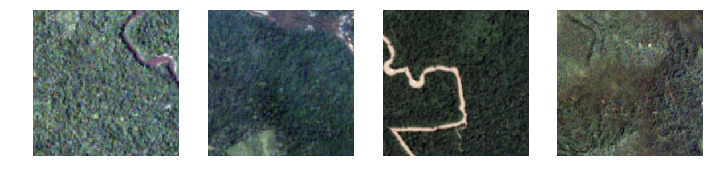

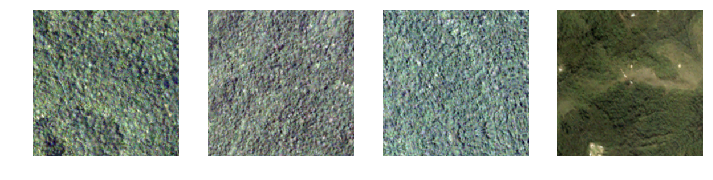

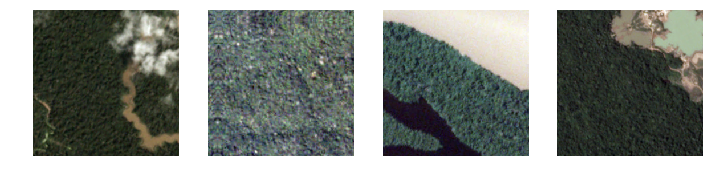

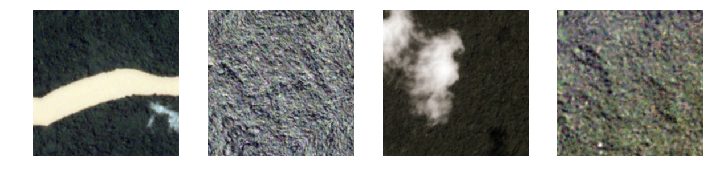

In [69]:
loop_max_counter = 1
for x, y_true, info in val_flow:
        
    y_pred = cnn.predict_on_batch(x)
    n = 4
    for counter in range(params['batch_size']):
        print("\n--", info[counter])
        print('y_true: ', y_true[counter, :])
        print('y_pred: ', y_pred[counter, :])        
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        if channels_first:
            img = x[counter, :, :, :].transpose([1, 2, 0])
        else:
            img = x[counter, :, :, :]
        plt.imshow(scale_percentile(img, q_min=0.0, q_max=100.0))
#         plt.imshow(img)        
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break
    